# Dynamics 365 Business Central Troubleshooting Guide (TSG), data-related issues

This notebook contains Kusto queries that can help getting to the root cause of an data-related issue for an environment. 

NB! Some of the signal used in this notebook is only available in newer versions of Business Central, so check the version of your environment if some sections do not return any data. The signal documentation states in which version a given signal was introduced.


## 1\. Get setup: Load up Python libraries and connect to Application Insights
First you need to set the notebook Kernel to Python3, load the KQLmagic module (did you install it?) and connect to your Application Insights resource (get appid and appkey from the API access page in the Application Insights portal)


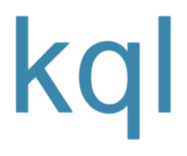

In [2]:
# load the KQLmagic module
%reload_ext Kqlmagic

In [3]:
# Connect to the Application Insights API
%kql appinsights://appid='<add app id from the Application Insights portal>';appkey='<add API key from the Application Insights portal>'

## 2\. Define filters

This workbook is designed for troubleshooting a single environment. Please provide values for aadTenantId and environmentName (or use a config file).

In [4]:
# Add values for AAD tenant id, environment name, and date range.
# It is possible to leave the value for AAD tenant id or environment name blank (if you want to analyze across all values of the parameter)

# You can either use configuration file (INI file format) or set filters directly. 

# If you specify a config file, then variables set here takes precedence over manually set filter variables
# config file name and directory (full path)
configFile = "c:\\tmp\\notebook.ini"


# Add AAD tenant id and environment name here
aadTenantId = ""
environmentName = ""

# date filters for the analysis
# use YYYY-MM-DD format for the dates (ISO 8601)
startDate = "2021-11-20"
endDate = "2022-01-01"




# Do not edit this code section
import configparser
config = configparser.ConfigParser()

config.read(configFile)

if bool(config.defaults()):
    if config.has_option('DEFAULT', 'aadTenantId'):
        aadTenantId = config['DEFAULT']['aadTenantId']
    if config.has_option('DEFAULT', 'environmentName'):
        environmentName = config['DEFAULT']['environmentName']
    if config.has_option('DEFAULT', 'extensionId'):
        extensionId = config['DEFAULT']['extensionId']
    if config.has_option('DEFAULT', 'startDate'):    
        startDate = config['DEFAULT']['startDate']
    if config.has_option('DEFAULT', 'endDate'):
        endDate = config['DEFAULT']['endDate']

print("Using these parameters for the analysis:")
print("----------------------------------------")
print("aadTenantId         " + aadTenantId)
print("environmentName     " + environmentName)
print("startDate           " + startDate)
print("endDate             " + endDate)

Using these parameters for the analysis:
----------------------------------------
aadTenantId         
environmentName     
startDate           2021-11-20
endDate             2022-01-01


# Analyze database usage
Now you can run Kusto queries to look for possible root causes for issues about data.

Either click **Run All** above to run all sections, or scroll down to the type of analysis you want to do and manually run queries

## Long Running SQL Queries

Performance tuning guide: [Efficient data access](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#efficient-data-access)

Database telemetry docs: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-long-running-sql-query-trace

KQL samples: https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/Long%20Running%20SQL%20Queries.kql

In [5]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0005'
| summarize count() by bin(timestamp, 1d)
| render timechart title= 'Number of long running SQL queries'

[]

In [6]:
%%kql
// 
// top 10 objects with long running sql queries
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0005'
    and customDimensions.alObjectId != '0'
| extend sqlStatement = tostring(customDimensions.sqlStatement)
, alObjectId = tostring(customDimensions.alObjectId)
, alObjectName = tostring( customDimensions.alObjectName )
, alObjectType = customDimensions.alObjectType
, alStackTrace = customDimensions.alStackTrace
, executionTimeInMS = toreal(totimespan(customDimensions.executionTime))/10000 //the datatype for executionTime is timespan 
, extensionName = tostring( customDimensions.extensionName )
| summarize count(), sumOfExecutionTimeInMS=sum(executionTimeInMS), medianExecutionTimeInMS=percentile(executionTimeInMS, 50) by alObjectId, alObjectName, extensionName
| order by medianExecutionTimeInMS desc
| limit 10

Empty DataFrame
Columns: [alObjectId, alObjectName, extensionName, count_, sumOfExecutionTimeInMS, medianExecutionTimeInMS]
Index: []

[]

## Database locks

Performance tuning guide: [Avoid locking](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-application#avoid-locking)

Database locks telemetry docs: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-database-locks-trace

KQL samples: https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/LockTimeouts.kql


In [7]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0012'
| summarize request_count=count() by bin(timestamp, 1d)
| render timechart title= 'Number of database lock timeouts'

[]

In [ ]:
%%kql
// 
// top 10 objects that experience database lock timeouts
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0012'
| extend sqlStatement = tostring(customDimensions.sqlStatement)
, alObjectId = tostring(customDimensions.alObjectId)
, alObjectName = tostring( customDimensions.alObjectName )
, alObjectType = customDimensions.alObjectType 
, extensionName = tostring( customDimensions.extensionName )
| summarize count() by alObjectId, alObjectName, extensionName
| order by count_ desc
| limit 10

## Reports

Performance tuning guide: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#setbasedmethods

Report telemetry docs: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-reports-trace

KQL samples: 
* https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/Reports.kql
* https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/PerformanceTuning/ReportExecution.kql

In [ ]:
%%kql
// 
// top 10 reports that have a low sqlratio
// 
// The higher the number called sqlratio is, the more set-based the report is (it tells you how many sql rows are read per sql statement)
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0006'
| project numberOfRows = toint(customDimensions.numberOfRows)
, sqlRowsRead = toint( customDimensions.sqlRowsRead )
, sqlExecutes = toint( customDimensions.sqlExecutes )
, alObjectName = tostring( customDimensions.alObjectName )
, alObjectId = tostring( customDimensions.alObjectId )
, extensionPublisher = tostring(customDimensions.extensionPublisher )
| where isnotnull( sqlExecutes ) and isnotnull( sqlRowsRead )
| summarize numberOfReportExecutions=count(), totalRows=sum(numberOfRows), totalSQLExecutes = sum(sqlExecutes), totalSQLRowsRead = sum(sqlRowsRead) by alObjectId, alObjectName
| extend sqlratio = toreal(totalSQLRowsRead)/totalSQLExecutes
, datasetratio = toreal(totalRows)/totalSQLExecutes
| order by sqlratio asc
| limit 10